<a href="https://colab.research.google.com/github/bartwronski/BlogPostsExtraMaterial/blob/master/PBR_textures_low_rank_part_3_PBR_materials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage
import urllib.request
from zipfile import ZipFile

Load a material from a zip file.

In [0]:
urllib.request.urlretrieve('https://www.dropbox.com/s/h2jir69q1ipk09o/PavingStones054_2K-JPG.zip?dl=1', filename='zip.zip')
texture_names = []
with ZipFile('zip.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()
   texture_names = zipObj.namelist()

Data preprocessing - load the textures, convert the grayscale ones to a single channel, and concatenate them along "channel" axis.
Keep the original indices referring to which channel corresponds to which texture index and name.


In [0]:
all_pbr_channels_concat = None
orig_tex_indices = []
init = False
for tex_name in texture_names:
  test_img = cv2.imread(tex_name)[:,:,(2,1,0)] / 255.0
  test_img_copy = test_img.copy()
  # simple stupid test if it's grayscale~ish
  if np.mean(test_img[:,:,0]-test_img[:,:,1]) < 0.0001:
    test_img = test_img[:,:,[0]]
  if not init:
    init = True
    all_pbr_channels_concat = test_img.copy()
    orig_tex_indices.append((0, test_img.shape[2], tex_name))
  else:
    print(all_pbr_channels_concat.shape, test_img.shape)
    orig_tex_indices.append((orig_tex_indices[-1][1], orig_tex_indices[-1][1] + test_img.shape[2], tex_name))
    all_pbr_channels_concat = np.concatenate((all_pbr_channels_concat, test_img), axis=2)
print(orig_tex_indices)
print(all_pbr_channels_concat.shape)

(2048, 1365, 1) (2048, 1365, 3)
(2048, 1365, 4) (2048, 1365, 1)
(2048, 1365, 5) (2048, 1365, 3)
(2048, 1365, 8) (2048, 1365, 1)
[(0, 1, 'PavingStones054_2K_AmbientOcclusion.jpg'), (1, 4, 'PavingStones054_2K_Color.jpg'), (4, 5, 'PavingStones054_2K_Displacement.jpg'), (5, 8, 'PavingStones054_2K_Normal.jpg'), (8, 9, 'PavingStones054_2K_Roughness.jpg')]
(2048, 1365, 9)


Function for "unconcatenating" and displaying the material.

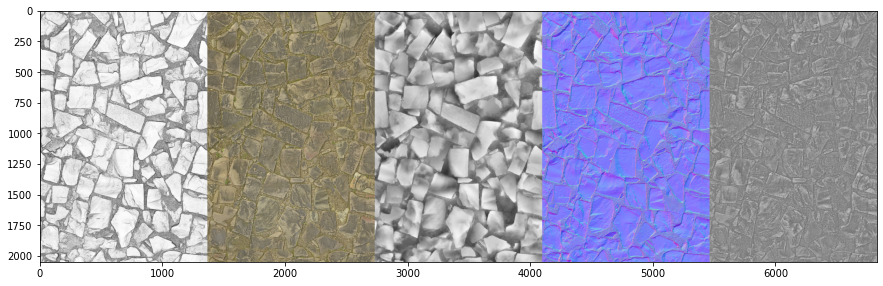

In [0]:
def display_from_concat(x):
  recons_stacked = None
  for i,l in enumerate(orig_tex_indices):
    slice = x[:,:,l[0]:l[1]]
    if (l[1] - l[0] == 1):
      slice = slice[:,:,[0,0,0]]
    if i == 0:
      recons_stacked = slice.copy()
    else:
      recons_stacked = np.concatenate((recons_stacked,slice), axis=1)
  return recons_stacked

plt.rcParams['figure.figsize']=15,15
plt.imshow(display_from_concat(all_pbr_channels_concat))

Flatten/unflatten to SVD friendly representation.

In [0]:
def flatten(x):
  return x.reshape(all_pbr_channels_concat.shape[0]*all_pbr_channels_concat.shape[1],all_pbr_channels_concat.shape[2])
def unflatten(x):
  return x.reshape(all_pbr_channels_concat.shape[0],all_pbr_channels_concat.shape[1],all_pbr_channels_concat.shape[2])


PSNR helper function.

In [0]:
def psnr(img1, img2, w = None):
  mse = np.mean( (img1 - img2) ** 2 )
  if mse == 0:
    return 100
  return -10 * np.log10(mse)

psnr(flatten(all_pbr_channels_concat), np.mean(flatten(all_pbr_channels_concat),axis=0))

18.012281764318697

Actual centered weightedSVD code - pretty minimal! 

In [0]:
def weighted_centered_svd(x, w):
  channels_to_compress = flatten(x) - np.mean(flatten(x),axis=0)
  channels_to_compress *= w
  u, s, v = np.linalg.svd(channels_to_compress, full_matrices=False)
  return u, s, v
def undo_weighted_centered_svd(x, u, s, v, w):
  return unflatten(np.dot(u, np.dot(np.diag(s), v))/w + np.mean(flatten(x),axis=0))

Display contributions of different input channels to the singular values and the output channels.
Plot the singular values - their value and normalized cumulative.

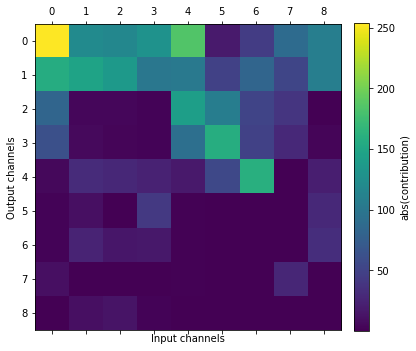

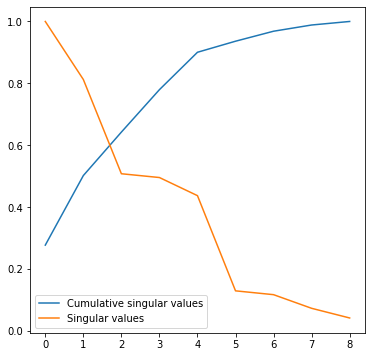

In [0]:
u, s, v = weighted_centered_svd(all_pbr_channels_concat, np.ones(all_pbr_channels_concat.shape[2]))
plt.rcParams['figure.figsize']=6,6
plt.matshow(np.abs(np.dot(np.diag(s),v)))
plt.xlabel('Input channels')
plt.ylabel('Output channels')
plt.colorbar(fraction=0.046, pad=0.04, label='abs(contribution)')
plt.show()
plt.plot(np.cumsum(s)/np.cumsum(s)[-1], label='Cumulative singular values')
plt.plot(s/s[0], label='Singular values')
plt.legend()
plt.show()

Display how the output / "compressed" channels look like when weighted by the singular values.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


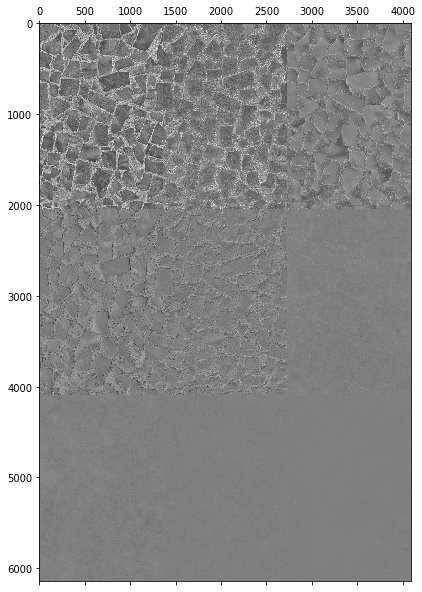

In [0]:
u_to_compress=unflatten(np.dot(u, np.diag(s)))
h1 = np.hstack((u_to_compress[:,:,[0,0,0]],u_to_compress[:,:,[1,1,1]],u_to_compress[:,:,[2,2,2]]))
h2 = np.hstack((u_to_compress[:,:,[3,3,3]],u_to_compress[:,:,[4,4,4]],u_to_compress[:,:,[5,5,5]]))
h3 = np.hstack((u_to_compress[:,:,[6,6,6]],u_to_compress[:,:,[7,7,7]],u_to_compress[:,:,[8,8,8]]))
plt.rcParams['figure.figsize']=10,10
plt.matshow(np.vstack((h1,h2,h3))/ np.max(u_to_compress[:,:,0])*0.5 + 0.5)
plt.show()

Show crops of compressed channels when displayed as RGB.

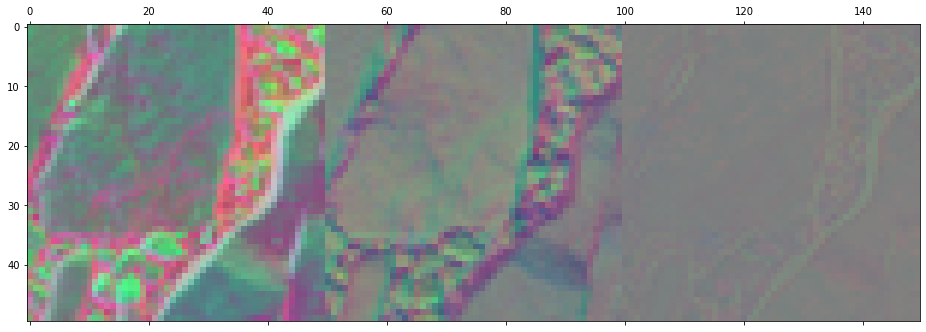

In [0]:
u_to_compress=u_to_compress[0:50,0:50,:]
plt.rcParams['figure.figsize']=8,8
plt.matshow(np.hstack((u_to_compress[:,:,0:3],u_to_compress[:,:,3:6],u_to_compress[:,:,6:9]))/ np.max(u_to_compress[:,:,0])*0.5 + 0.5)
plt.show()

Plot the PSNR of keeping only "k" components - total as well as per-texture.

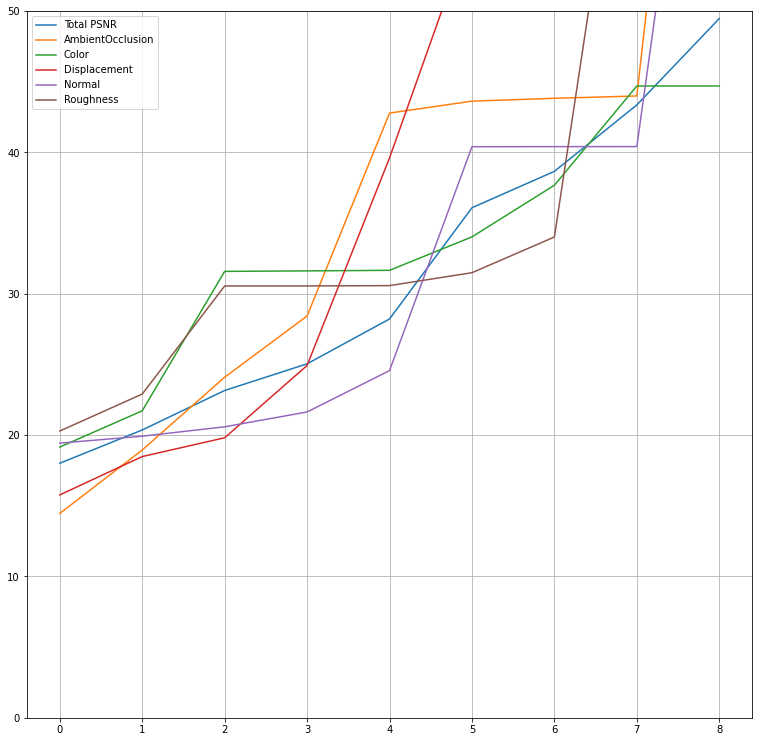

In [0]:
psnrs = np.zeros((9,6))
plt.rcParams['figure.figsize']=13,13

for k in range(9):
  # keep k components only
  s_copy = np.zeros_like(s)
  s_copy[0:k]=s[0:k]
  
  recons = undo_weighted_centered_svd(all_pbr_channels_concat, u, s_copy, v, np.ones(all_pbr_channels_concat.shape[2]))
  psnrs[k, 0] = psnr(recons, all_pbr_channels_concat)
  for i, l in enumerate(orig_tex_indices):
    psnrs[k, i+1] = psnr(recons[:,:,l[0]:l[1]], all_pbr_channels_concat[:,:,l[0]:l[1]])
for p in range(6):
  plt.ylim(0, 50)
  plt.plot(psnrs[:,p], label='Total PSNR' if p == 0 else orig_tex_indices[p-1][2].split('_')[-1].split('.')[-2])
plt.grid()
plt.legend()

Display PSNRs as well as visual results when downsampling / subsampling some of the compressed channels.

33.77201251297122
45.3876157611172
37.76260474417699
45.20640730192647
30.090872026410175
35.576121551031164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


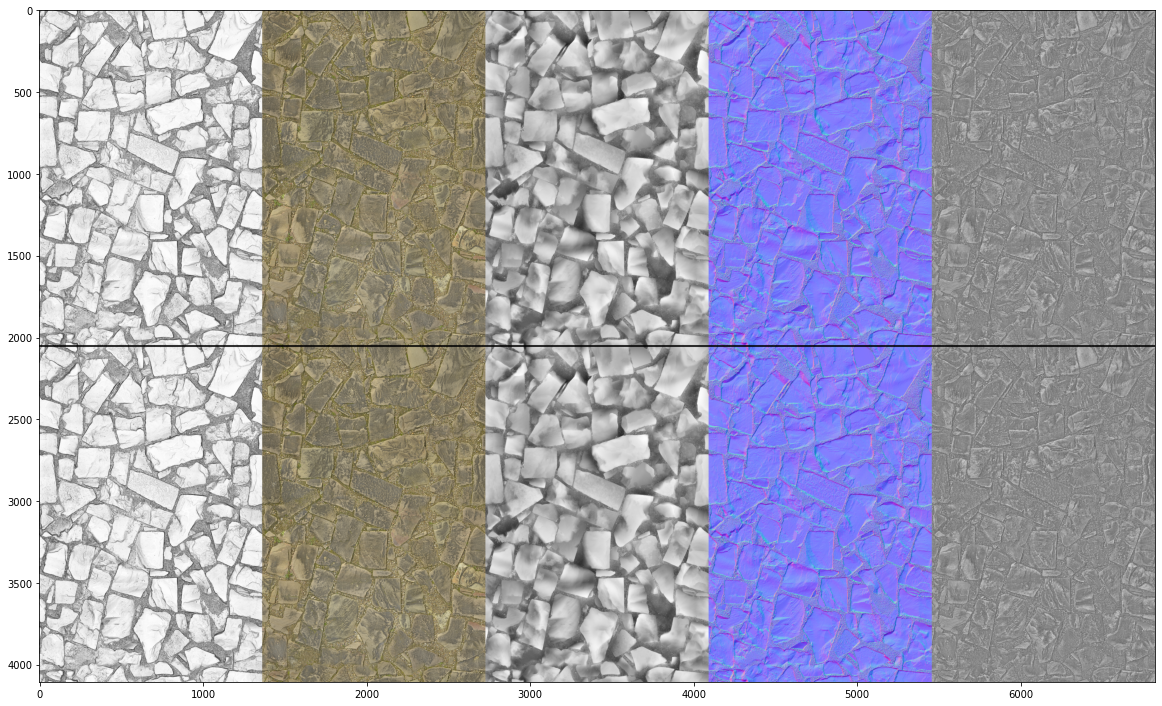

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


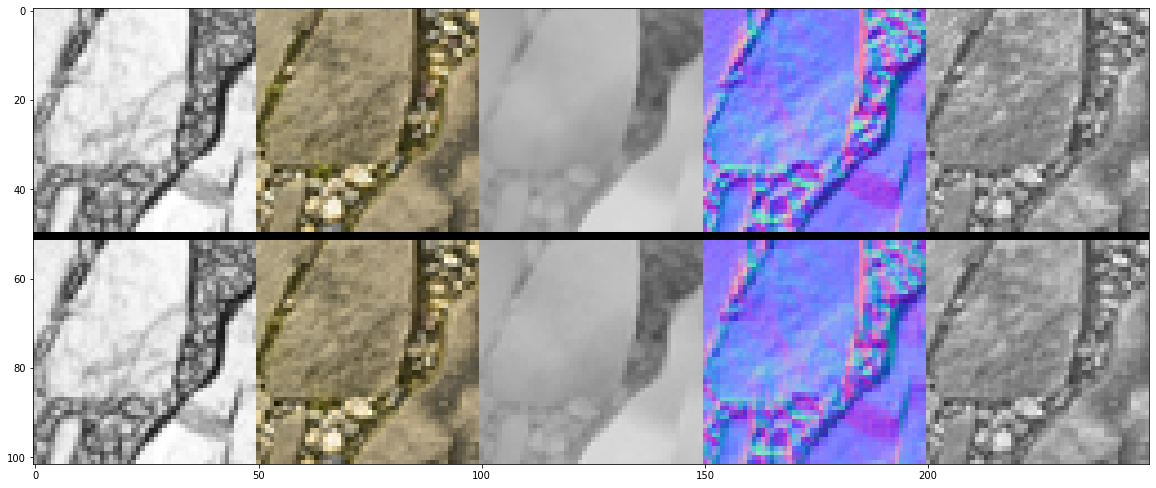

In [0]:
def compress_subsample(u, s, v, w):
  u_to_compress= unflatten(u).copy()
  # Box filter and subsample by 2
  for c in (4,5,6):
    u_to_compress[0::2,:,c] = u_to_compress[1::2,:,c] = (u_to_compress[0::2,:,c]+u_to_compress[1::2,:,c])/2.0
    u_to_compress[:,0:-1:2,c] = u_to_compress[:,1::2,c] = (u_to_compress[:,0:-1:2,c]+u_to_compress[:,1::2,c])/2.0
  # Box filter and subsample by 4
  for c in (7,8):
    avg = (u_to_compress[0::4,:,c]+u_to_compress[1::4,:,c]+u_to_compress[2::4,:,c]+u_to_compress[3::4,:,c])/4.0
    u_to_compress[0::4,:,c] = u_to_compress[1::4,:,c] = u_to_compress[2::4,:,c] = u_to_compress[3::4,:,c]= avg
    avg = (u_to_compress[:,0:-1:4,c] + u_to_compress[:,1:-1:4,c] + u_to_compress[:,2:-1:4,c] + u_to_compress[:,3:-1:4,c])/4.0
    u_to_compress[:,0:-1:4,c] = u_to_compress[:,1:-1:4,c] =u_to_compress[:,2:-1:4,c] =u_to_compress[:,3:-1:4,c] =avg
  return undo_weighted_centered_svd(all_pbr_channels_concat, u_to_compress, s, v, w)

recons=compress_subsample(u, s, v, np.ones(all_pbr_channels_concat.shape[2]))
print(psnr(recons, all_pbr_channels_concat))
for i, l in enumerate(orig_tex_indices):
    print(psnr(recons[:,:,l[0]:l[1]], all_pbr_channels_concat[:,:,l[0]:l[1]]))

plt.rcParams['figure.figsize']=20,20
plt.imshow(np.vstack((display_from_concat(all_pbr_channels_concat), np.zeros((10,display_from_concat(all_pbr_channels_concat).shape[1],3)), display_from_concat(recons))))
plt.show()
# crops
plt.imshow(np.vstack((display_from_concat(all_pbr_channels_concat[0:50,0:50,:]), np.zeros((2,display_from_concat(all_pbr_channels_concat[0:50,0:50,:]).shape[1],3)), display_from_concat(recons[0:50,0:50,:]))))
plt.show()

One more, final example - this time with downweighting the heightmap and AO. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


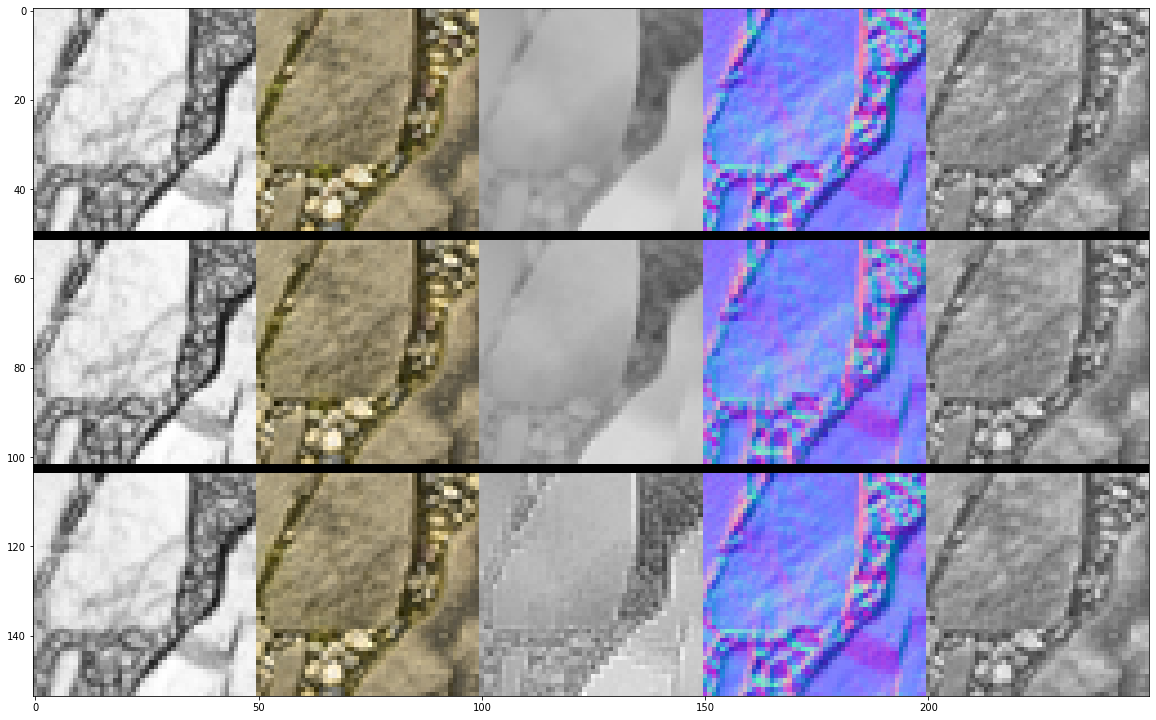

In [0]:
recons_copy = recons.copy()
w = np.ones(all_pbr_channels_concat.shape[2])
w[0] = 0.8
w[4] = 0.85
u, s, v = weighted_centered_svd(all_pbr_channels_concat, w)

recons=compress_subsample(u, s, v, w)

plt.imshow(np.vstack((display_from_concat(all_pbr_channels_concat[0:50,0:50,:]), np.zeros((2,display_from_concat(all_pbr_channels_concat[0:50,0:50,:]).shape[1],3)), display_from_concat(recons_copy[0:50,0:50,:]), np.zeros((2,display_from_concat(all_pbr_channels_concat[0:50,0:50,:]).shape[1],3)), display_from_concat(recons[0:50,0:50,:]))))
plt.show()
